In [1]:
# import packages
import numpy as np
import os
from matplotlib import pyplot as plt
import time

from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.utils import plot_1d_layer_model, model_builder, plot2Ddata

from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    Solver
)

from discretize import TensorMesh, TreeMesh

from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

import matplotlib as mpl

## Define a mesh and a model

In [2]:
# Here we can either we can add a code to import a model instead in the future

dx = 0.05  # minimum cell width (base mesh cell width) in x
dy = 0.05  # minimum cell width (base mesh cell width) in y
dz = 0.05  # minimum cell width (base mesh cell width) in z

x_length = 2.0  # domain width in x
y_length = 2.0  # domain width in y
z_length = 2.0 # domain width in y

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine surface topography
padding_surface = [[0, 0, 0]]
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = np.zeros(np.shape(xx))
topo_xyz = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

mesh.refine_surface(topo_xyz, padding_cells_by_level=padding_surface, finalize=False)

# Refine core mesh region
padding = [[0, 0, 2]]
xp, yp, zp = np.meshgrid([-0.5, 0.5], [-0.5, 0.5], [-0.5, -0.2])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh.refine_bounding_box(xyz, padding_cells_by_level=padding, finalize=False)
mesh.finalize()

<Figure size 700x600 with 0 Axes>

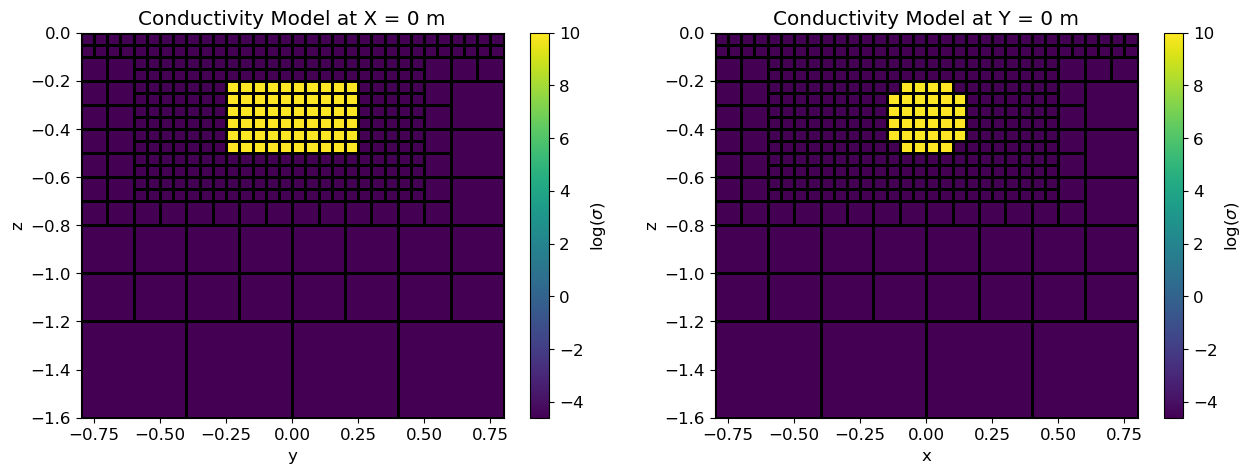

In [4]:
air_conductivity = 1e-8
background_conductivity = 1e-2
block_conductivity = 1e1

ind_active = active_from_xyz(mesh, topo_xyz)
nC = int(ind_active.sum())

model = np.log(background_conductivity) * np.ones(ind_active.sum())

active_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)
conductivity_map = active_map * maps.ExpMap(nP = mesh.nC)

starting_conductivity_model = np.log(background_conductivity) * np.ones(nC)

cylinder_center = [0, 0, -0.35]  # Center of the cylinder
cylinder_axis = [0, 1, 0]      # Axis direction (vector)
cylinder_radius = 0.15           # Radius of the cylinder
cylinder_length = 0.5           # Length of the cylinder

num_points = 15
angle = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

top_circle = [ cylinder_center + np.array([cylinder_radius * np.cos(a), cylinder_length / 2, cylinder_radius * np.sin(a)])
    for a in angle]
bottom_circle = [cylinder_center + np.array([cylinder_radius * np.cos(a), -cylinder_length / 2, cylinder_radius * np.sin(a)])
    for a in angle]

pts = np.vstack([top_circle, bottom_circle])

cylinder_inds = model_builder.get_indices_polygon(mesh=mesh, pts=pts)
model[cylinder_inds] = block_conductivity

# Plot log-conductivity model
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 6))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
plot_1 = mesh.plot_slice(model, normal="X", ax=ax1, ind=int(nbcx/2), grid=True,
                         clim=(np.min(model), np.max(model)))

plot_2 = mesh.plot_slice(model, normal="Y", ax=ax2, ind=int(nbcy/ 2),grid=True,
                         clim=(np.min(model), np.max(model)))

norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
ax1.set_title("Conductivity Model at X = 0 m")
cb = plt.colorbar(plot_1[0], ax=ax1, norm=norm, orientation="vertical")
cb.set_label(r"$\log(\sigma)$")

ax2.set_title("Conductivity Model at Y = 0 m")
cb = plt.colorbar(plot_2[0], ax=ax2, norm=norm, orientation="vertical")
cb.set_label(r"$\log(\sigma)$")

plt.show()

## Define Survey

In [5]:
# Frequencies being predicted
frequencies = [1000, 2000]

# Defining transmitter locations
N = 2
xtx, ytx, ztx = np.meshgrid(np.linspace(-0.8, 0.8, N), np.linspace(-0.8, 0.8, N), [0.1])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(np.linspace(-0.8, 0.8, N)+0.25, np.linspace(-0.8, 0.8, N), [0.1])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(len(frequencies)):
    for jj in range(ntx):
        # Define receivers of different type at each location
        bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "real"
        )
        bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "imag"
        )
        receivers_list = [bzr_receiver, bzi_receiver]

        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[ii],
                source_locations[jj],
                orientation="z",
                moment=4,
            )
        )

survey = fdem.Survey(source_list)
prob = fdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=conductivity_map, solver=Solver
)

In [6]:
t = time.time()

data = prob.make_synthetic_data(
    model, relative_error=0.05, noise_floor=1e-11, add_noise=False
)

dclean = data.dclean

print("Done forward simulation. Elapsed time = {:1.2f} s".format(time.time()))

Done forward simulation. Elapsed time = 1728437962.83 s


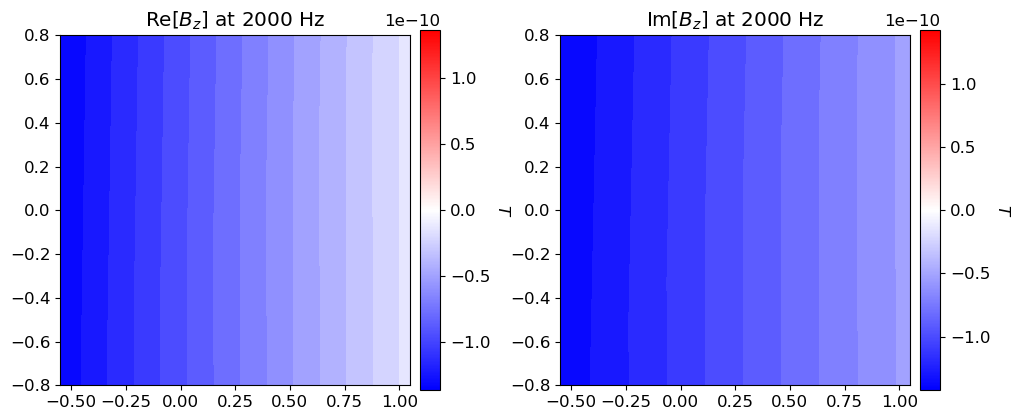

In [8]:
dpred = dclean
# Data are organized by frequency, transmitter location, then by receiver. We nFreq transmitters
# and each transmitter had 2 receivers (real and imaginary component). So
# first we will pick out the real and imaginary data
bz_real = dpred[0 : len(dpred) : 2]
bz_imag = dpred[1 : len(dpred) : 2]

# Then we will will reshape the data for plotting.
bz_real_plotting = np.reshape(bz_real, (len(frequencies), ntx))
bz_imag_plotting = np.reshape(bz_imag, (len(frequencies), ntx))

fig = plt.figure(figsize=(10, 4))

# Real Component
frequencies_index = 1

v_max = np.max(np.abs(bz_real_plotting[frequencies_index, :]))
ax1 = fig.add_axes([0.05, 0.05, 0.35, 0.9])
plot2Ddata(
    receiver_locations[:, 0:2],
    bz_real_plotting[frequencies_index, :],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title(f"Re[$B_z$] at {frequencies[frequencies_index]} Hz")

ax2 = fig.add_axes([0.41, 0.05, 0.02, 0.9])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$T$", rotation=270, labelpad=15, size=12)

# Imaginary Component
v_max = np.max(np.abs(bz_imag_plotting[frequencies_index, :]))
ax1 = fig.add_axes([0.55, 0.05, 0.35, 0.9])
plot2Ddata(
    receiver_locations[:, 0:2],
    bz_imag_plotting[frequencies_index, :],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title(f"Im[$B_z$] at {frequencies[frequencies_index]} Hz")

ax2 = fig.add_axes([0.91, 0.05, 0.02, 0.9])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$T$", rotation=270, labelpad=15, size=12)

plt.show()

In [12]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmisfit = data_misfit.L2DataMisfit(data=data, simulation=prob)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=ind_active,
    reference_model=starting_conductivity_model,
)

# regularization.reference_model_in_smooth = (
#     True  # Include reference model in smoothness
# )

# Define how the optimization problem is solved.
opt = optimization.InexactGaussNewton(maxIter=15)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(
    dmisfit, reg, opt
)

In [13]:
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)
# beta_schedule = directives.BetaSchedule(coolingFactor=2.5, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1)

# Apply and update preconditioner as the model updates
# update_jacobi = directives.UpdatePreconditioner()
directives_list = [
    starting_beta,
    # beta_schedule,
    target_misfit,
    # update_jacobi,
]

In [14]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(
    inv_prob, directiveList=directives_list
)

In [15]:
# Run inversion
m0 = np.log(background_conductivity) * np.ones(mesh.nC)
recovered_conductivity_model = inv.run(m0)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticFluxDensity problem***
                        


KeyboardInterrupt: 

In [ ]:
# Plot recovered model

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_axes([0.15, 0.15, 0.67, 0.75])
mesh.plot_slice(
    conductivity_map * recovered_conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=False,
    clim=(model.min(), model.max()),
    pcolor_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Recovered Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1000, 1000])
ax1.set_ylim([-1000, 0])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
norm = mpl.colors.Normalize(
    vmin=model.min(), vmax=model.max()
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.viridis, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)
plt.show()